## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


import warnings
warnings.filterwarnings('ignore')

## Reading the data

In [2]:
data = pd.read_csv("airline-passenger-traffic.csv", header = None)
data.head()

,0,1
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [3]:
data.shape

(144, 2)

In [4]:
data.columns = ["Month", "Passengers"]
data["Month"] = pd.to_datetime(data["Month"], format = '%Y-%m')
data = data.set_index('Month')
data.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<Axes: xlabel='Month'>

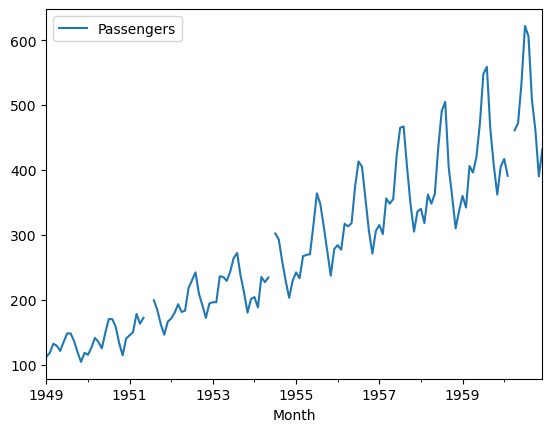

In [5]:
data.plot()

# Data Pre-processing

## Handling missing values

In [6]:
data[data.isnull().any(axis=1)]

,Passengers
Month,
1951-06-01,NaN
1951-07-01,NaN
1954-06-01,NaN
1960-03-01,NaN


### Mean Imputation

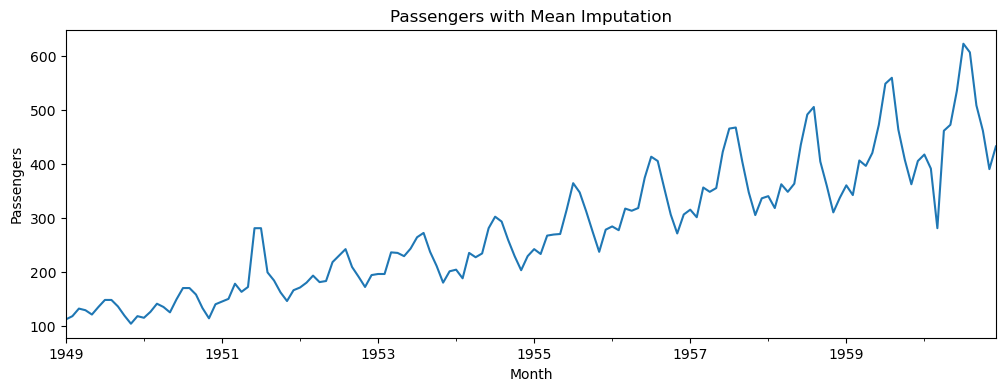

In [7]:
data["Passengers_Mean_imputation"] = data["Passengers"].fillna(data["Passengers"].mean())
data["Passengers_Mean_imputation"].plot(figsize=(12, 4))
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title("Passengers with Mean Imputation")
plt.show()

- 1951-06 & 1951-07 take higher values than expected.
- 1954-06 is alright.
- 1960-03 takes lower value than expected.

### Linear Interpolation
We fill missing values by connecting the values before and after the missing point with a straight line and estimating in between.

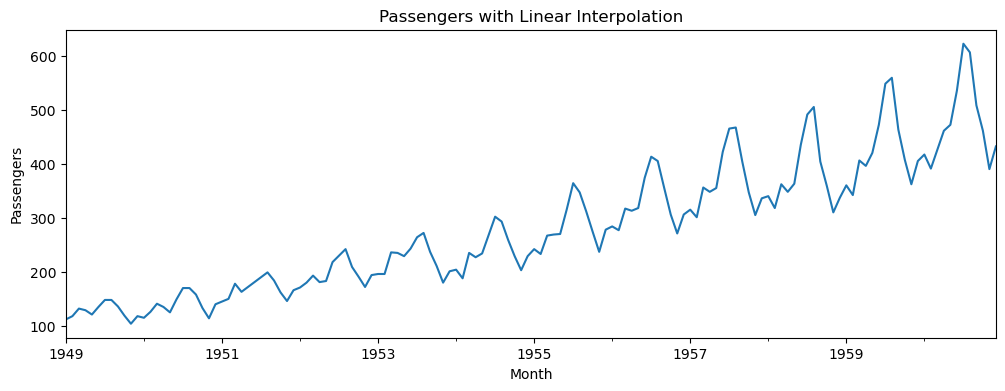

In [8]:
data["Passengers_Linear_Interpolation"] = data["Passengers"].interpolate(method="linear")
data["Passengers_Linear_Interpolation"].plot(figsize=(12, 4))
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title("Passengers with Linear Interpolation")
plt.show()

Looks better, we will move ahead with linear interpolation only.

In [9]:
data.head()

,Passengers,Passengers_Mean_imputation,Passengers_Linear_Interpolation
Month,,,
1949-01-01,112.0,112.0,112.0
1949-02-01,118.0,118.0,118.0
1949-03-01,132.0,132.0,132.0
1949-04-01,129.0,129.0,129.0
1949-05-01,121.0,121.0,121.0


In [10]:
# Dropping Passengers_Mean_imputation and Passengers columns.
# Renaming Passengers_Linear_Interpolation column to Passengers column.
data = data.drop(columns = ['Passengers', 'Passengers_Mean_imputation'])
data = data.rename(columns={'Passengers_Linear_Interpolation' : 'Passengers'})
data.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


## Handling outliers

Q1:  180.75
Q2:  267.5
Q3:  360.5
Quartile-range:  179.75


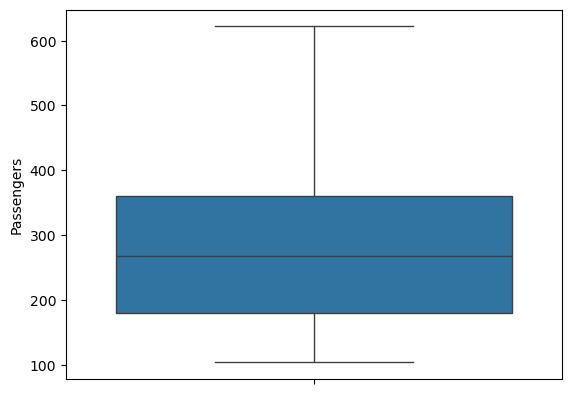

In [11]:
sns.boxplot(data['Passengers'])
print("Q1: ", data['Passengers'].quantile(0.25))
print("Q2: ", data['Passengers'].quantile(0.5))
print("Q3: ", data['Passengers'].quantile(0.75))
print("Quartile-range: ", data['Passengers'].quantile(0.75) - data['Passengers'].quantile(0.25))

No outliers detected.

# EDA

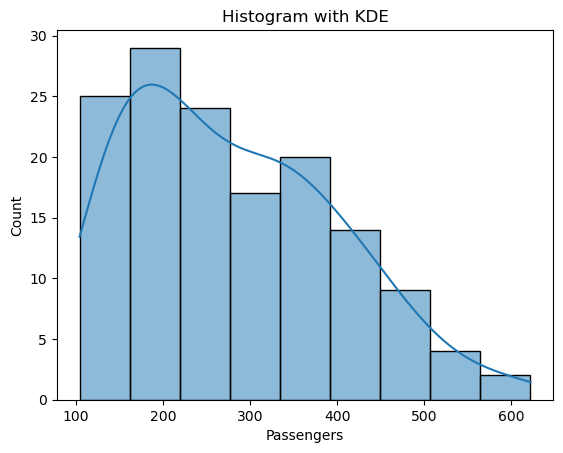

In [12]:
sns.histplot(data['Passengers'], kde=True)
plt.xlabel("Passengers")
plt.title("Histogram with KDE")
plt.show()

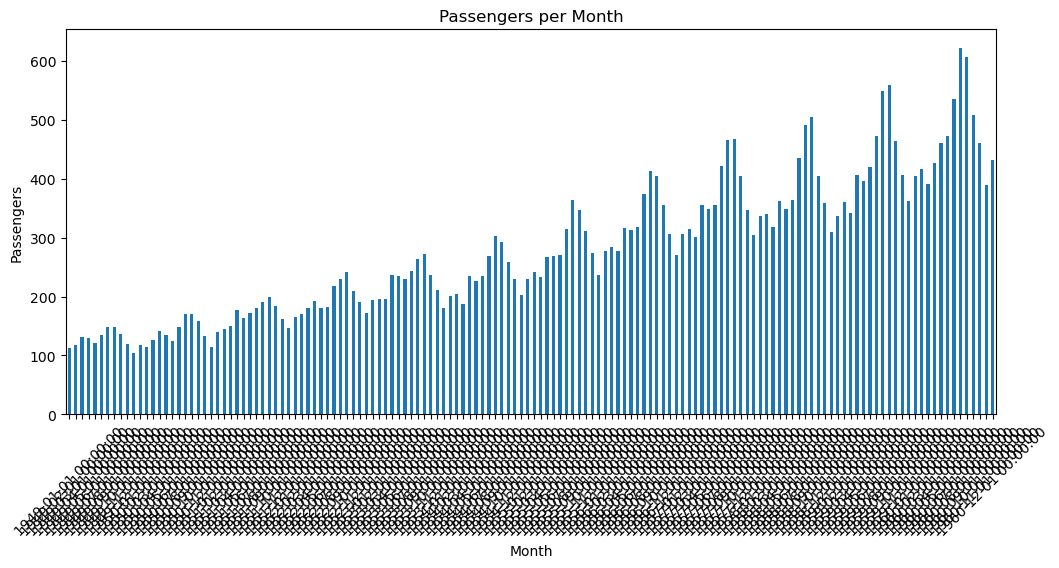

In [13]:
data['Passengers'].plot(kind='bar', figsize=(12, 5))
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title("Passengers per Month")
plt.xticks(rotation=45)
plt.show()

# Time Series Decomposition

## Additive seasonal decomposition

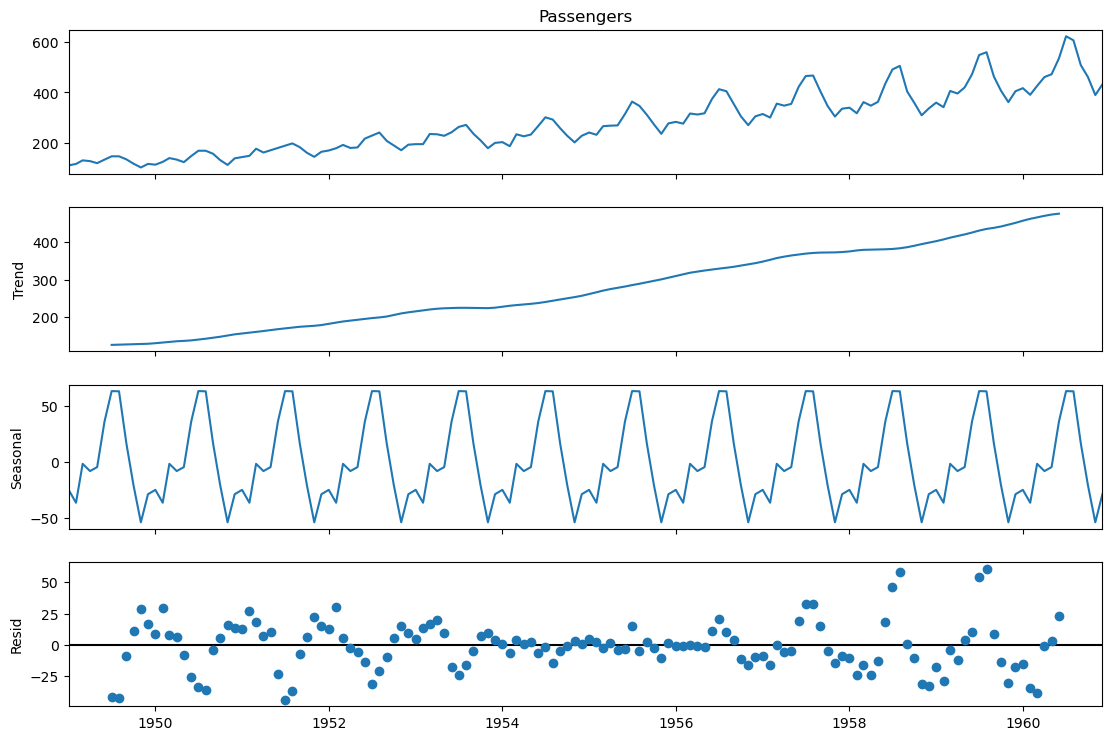

In [14]:
decomposition_add = sm.tsa.seasonal_decompose(data['Passengers'], model='additive')
fig = decomposition_add.plot()
fig.set_size_inches(12, 8)  
plt.show()

#### Analysis:-
1. Actual data
2. ***Trend*** - Increasing trend.
3. ***Seasonal*** - 
    - Varies from +50 to -50 with the mean 0. 
    - Each cycle represents each year trend.
    - The value in the Y-axis has to be `added` to the Trend plot value to get the actual value of that year. E.g.:- For the year 1950 Nov, the seasonal value is +50 and the trend value is 100. Hence, teh actual value(passengers number) will (seasonal+Trend) value = 50+100 = 150.
4. ***Residual*** - It is the noise pattern of the time series data for each year, which was not captured by the two components - Trend and Seasonality. Residual is the left over after decomposition of the two major components (Trend and Seasonality)

## Multiplicative Seasonal Decomposition

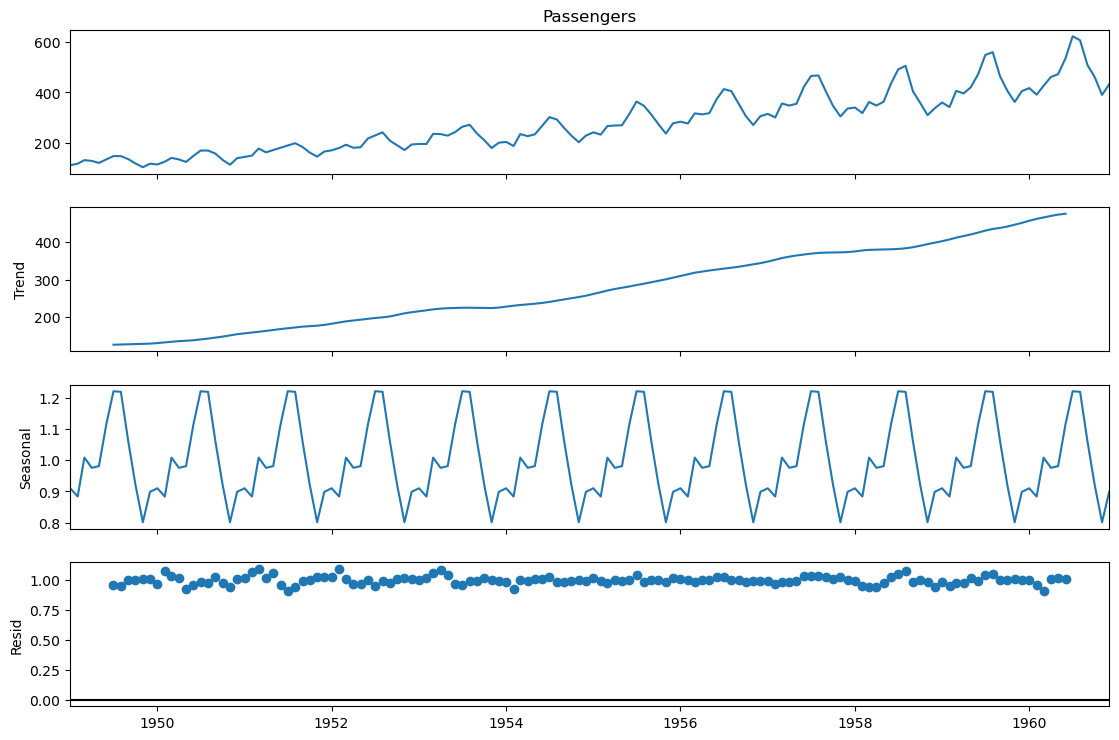

In [15]:
decomposition_mult = sm.tsa.seasonal_decompose(data['Passengers'], model='multiplicative')
fig = decomposition_mult.plot()
fig.set_size_inches(12, 8)  
plt.show()

#### Analysis:-

***Seasonal*** - 
1. Varies from 0.8 to 1.2 
2. The value in the Y-axis has to be `multiplied` to the Trend plot value to get the actual value of that year. E.g.:- For the year 1950 Nov, the seasonal value is `1.2` and the trend value is `100`. Hence, the actual value(passengers number) will (seasonal X Trend) value = 1.2 X 100 = 120.


# Time Series Forecasting

## Checking for stationarity

### 1. Visual Inspection

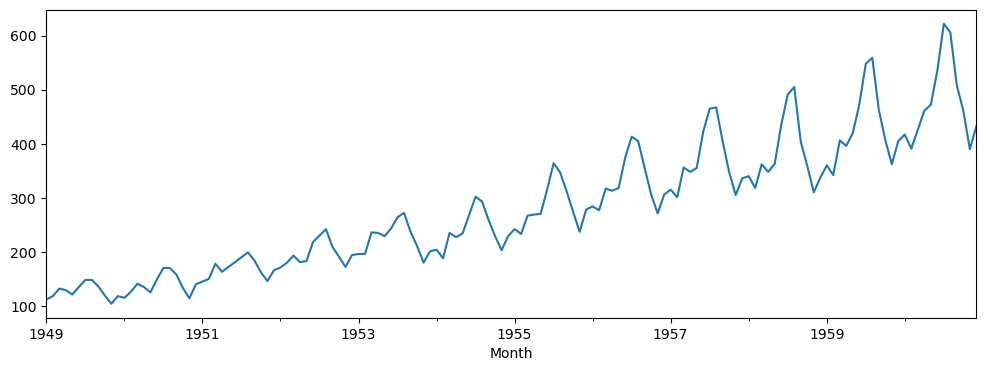

In [16]:
data["Passengers"].plot(figsize = (12,4))
plt.show()

1. There is an upward trend.(changing mean)
2. The spread of values is changing with time.(changing variance - Heteroscedasticity)
3. There are regular seasonal spikes( mean & variance are time dependent).

Hence, the time series is not stationary.
A non-stationary time series typically shows changing mean, changing variance, trend, seasonality, or persistent autocorrelation. That’s why we apply differencing, detrending, and seasonal adjustment to make it stationary before modeling.

### 2. Augmented Dickey-Fuller Test(ADF Test)
H0: The series is non-stationary.

H1: The series is stationary.

In [17]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(data['Passengers'])

print('ADF Statistic: %0.2f' % adf_test[0])
print('p-value: %0.2f' %adf_test[1])
print('Critical value at 5% level of significance:', adf_test[4]['5%'])

if adf_test[1] <= 0.05:
    print("Reject H0 → Stationary")
else:
    print("Fail to Reject H0 → Non-Stationary")

ADF Statistic: 0.89
p-value: 0.99
Critical value at 5% level of significance: -2.8840418343195267
Fail to Reject H0 → Non-Stationary


### 3. KPSS Test
H0: The series is stationary.

H1: The series is non-stationary.

In [18]:
from statsmodels.tsa.stattools import kpss

kpss_test = kpss(data['Passengers'])

print("KPSS Statistic:", kpss_test[0])
print("p-value:", kpss_test[1])
print("Critical Values:", kpss_test[3])

if kpss_test[1] <= 0.05:
    print("Reject H0 → Non-Stationary")
else:
    print("Fail to Reject H0 → Stationary")

KPSS Statistic: 1.6511897469421617
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject H0 → Non-Stationary


## Converting Non-stationary into Stationary Time Series
- If difference-stationary → apply differencing.
- If variance not constant → log / Box-Cox transform.
- If seasonality → seasonal adjustment or differencing.

After transformation, re-run ADF/KPSS to confirm stationarity.

### 1. Log Transformation

In [19]:
data_log = pd.Series(np.log(data['Passengers']), index=data.index)
print(data_log.head())

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: Passengers, dtype: float64


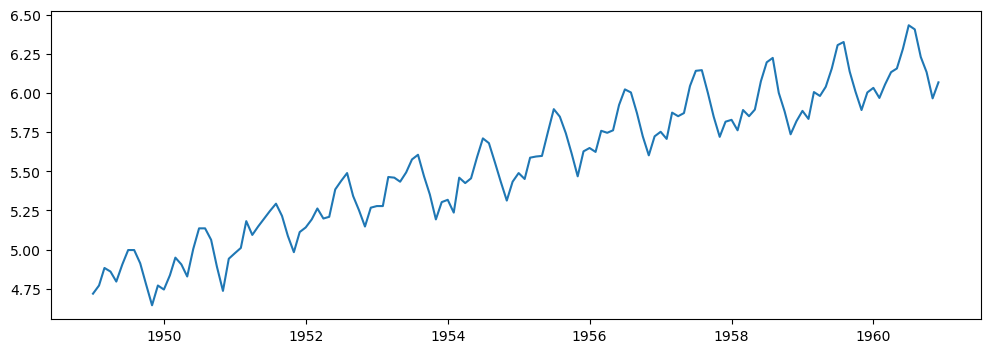

In [20]:
plt.figure(figsize = (12,4))
plt.plot(data_log, label='After Box Cox Transformation')
plt.show()

- We can see the variance has become almost constant after the transformation.
- But we can see that the series still has an upward trend. So, the mean is not constant yet. Hence, we need to do Differencing to make the mean constant.

In [21]:
adf_test = adfuller(data_log)

print('ADF Statistic: %0.2f' % adf_test[0])
print('p-value: %0.2f' %adf_test[1])
print('Critical value at 5% level of significance:', adf_test[4]['5%'])

if adf_test[1] <= 0.05:
    print("Reject H0 → Stationary")
else:
    print("Fail to Reject H0 → Non-Stationary")

ADF Statistic: -1.71
p-value: 0.43
Critical value at 5% level of significance: -2.8840418343195267
Fail to Reject H0 → Non-Stationary


### 2. Differencing
Differencing is performed by subtracting the previous observation from the current observation making the series stationary.
- Removes trend and seasonality from a time series. 
- Seasonality is removed (not by ordinary differencing) by seasonal differencing with lag equal to the cycle length.

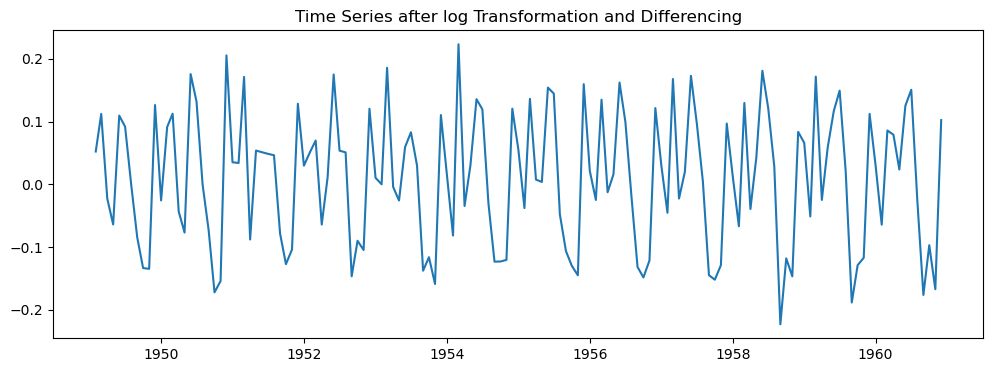

In [22]:
# First order differencing
data_log_diff = pd.Series(data_log - data_log.shift(), index=data.index)
# Dropping the first NaN (since first observation has no previous value)
data_log_diff.dropna(inplace=True)

# Plotting the Time series after Box Cox transformation and Differencing
plt.figure(figsize=(12,4))
plt.plot(data_log_diff)
plt.title("Time Series after log Transformation and Differencing")
plt.show()

- Tthere is no trend (upward or downward) after differencing on the log transformed data. 
- The mean has become constant (zero).
- Also, the variance is almost constant.

Check again for stationarity.

In [23]:
adf_test_2 = adfuller(data_log_diff)
print('ADF Statistic: %0.2f' % adf_test_2[0])
print('p-value: %0.2f' %adf_test_2[1])
print('Critical value at 5% level of significance:', adf_test_2[4]['5%'])

if adf_test_2[1] <= 0.05:
    print("Reject H0 → Stationary")
else:
    print("Fail to Reject H0 → Non-Stationary")

ADF Statistic: -3.29
p-value: 0.02
Critical value at 5% level of significance: -2.8840418343195267
Reject H0 → Stationary


## Making ACF and PACF plots

AR (AutoRegressive):
- PACF → cuts off after p lags (shows order of AR).
- ACF → decays slowly.

MA (Moving Average):
- ACF → cuts off after q lags.
- PACF → decays slowly.

ARMA:
- Both ACF & PACF decay slowly.

### 1. Auto Correlation Function (ACF) Plot
Autocorrelation refers to the correlation of a time series with its own lagged values.
- Shows correlation between current observation and its past lags.
- If a bar goes outside the confidence band, that lag is statistically significant.
- For seasonal data, big spikes appear at multiples of the seasonal period.

<Figure size 1600x400 with 0 Axes>

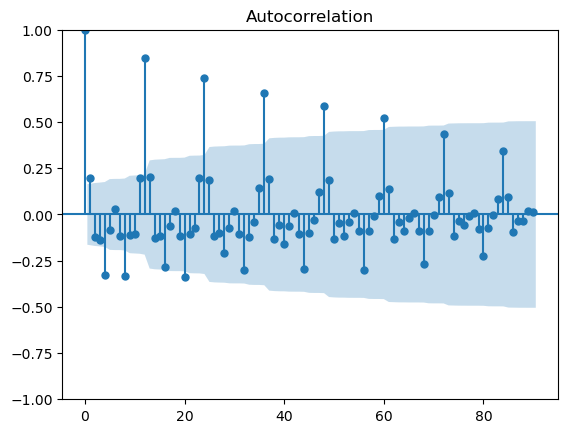

In [24]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(16,4))
plot_acf(data_log_diff, lags=90)
plt.show()

1. The shaded portion is less significant.
2. Clear annual seasonality (period = 12 months).
3. q = [1,4,8]

### 2. Partial Auto Correlation Function (PACF) Plot
Partial Autocorrelation measures the direct relationship between a time series and its lagged value, after removing the effects of all shorter lags.
- Shows correlation at each lag after removing effects of earlier lags.
- Useful for identifying AR (Auto-Regressive) terms in ARIMA.
- If a bar goes outside the confidence band, that lag is statistically significant.

<Figure size 1600x400 with 0 Axes>

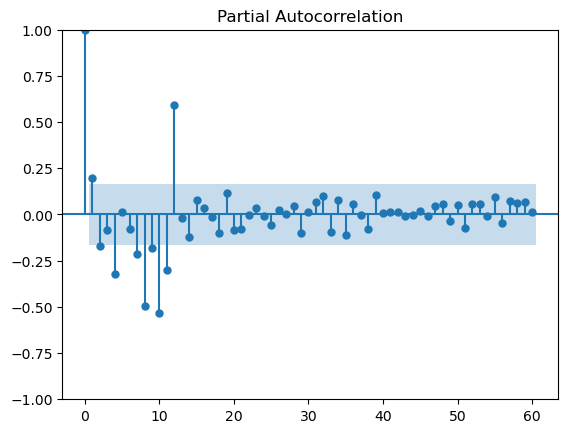

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(16,4))
plot_pacf(data_log_diff, lags=60)
plt.show()

Little change in the correlation plot. Because PACF only captures the direct correlation with the time lag. It bypasses the tile lags in between.

## Seasonal Differencing

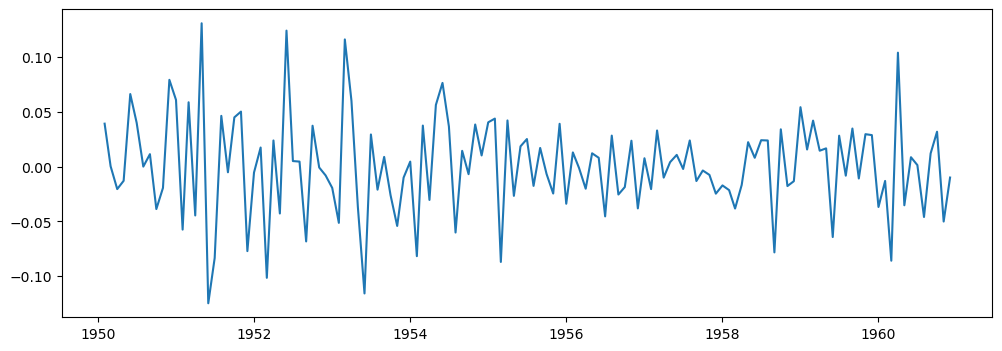

In [26]:
seasonal_diff = data_log_diff- data_log_diff.shift(12)
seasonal_diff.dropna(inplace=True)

plt.figure(figsize=(12,4))
plt.plot(seasonal_diff, label="After Seasonal Differencing (lag=12)")
plt.show()

### ACF plot and PACF plot after seasonal differencing(period = 12)

<Figure size 1000x400 with 0 Axes>

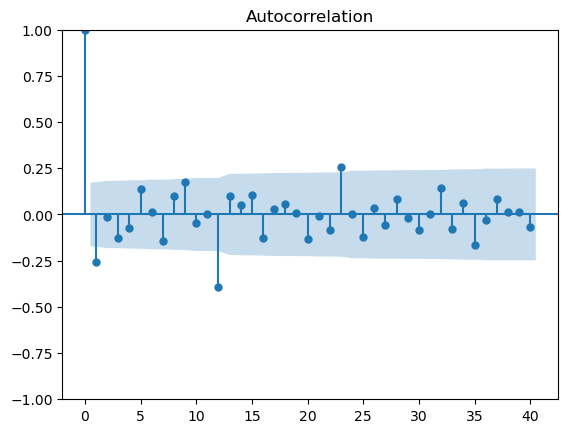

In [27]:
plt.figure(figsize=(10,4))
plot_acf(seasonal_diff, lags=40)
plt.show()

<Figure size 1000x400 with 0 Axes>

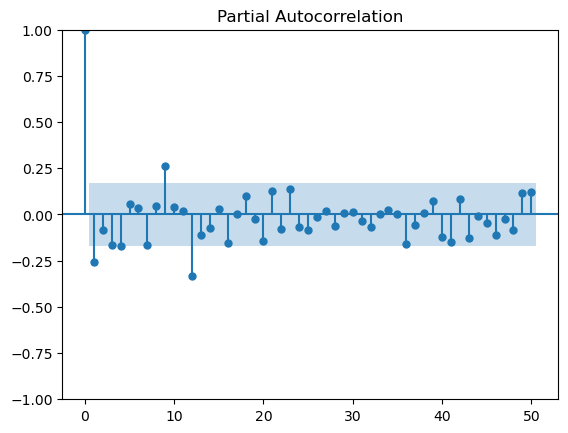

In [28]:
plt.figure(figsize=(10,4))
plot_pacf(seasonal_diff, lags=50)
plt.show()

From the above ACF & PACF plots, the possible values of p,q and P,Q are:

p = 1,3,4,7,9<br>
q = 1<br>
P = 1<br>
Q = 1,2

# Train-test split

In [29]:
train = data_log[:120]
test = data_log[120:]

## Model Fitting

In [30]:
orders = [(1,1,1), (3,1,1), (4,1,1), (7,1,1), (9,1,1)]
seasonal_orders = [(1,1,1,12), (1,1,2,12)]

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initialize best trackers
best_rmse = float('inf')
best_mape = float('inf')

best_model_rmse = None
best_model_mape = None

best_order_rmse = None
best_order_mape = None

best_seasonal_order_rmse = None
best_seasonal_order_mape = None

for order in orders:
    for seasonal_order in seasonal_orders:
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order).fit()

        predicted = model.predict(start=test.index[0], end=test.index[-1])
        actual = test
        rmse = ((actual - predicted)**2).mean()**0.5
        mape = (abs(actual - predicted)*100/actual).mean()
        print('{}{}: AIC = {}, BIC = {}, LLF = {}, MAPE = {}, RMSE = {}'.format(
            order, seasonal_order, model.aic, model.bic, model.llf, mape, rmse))

        # Track best by RMSE
        if rmse < best_rmse:
            best_rmse = rmse
            best_model_rmse = model
            best_order_rmse = order
            best_seasonal_order_rmse = seasonal_order

        # Track best by MAPE
        if mape < best_mape:
            best_mape = mape
            best_model_mape = model
            best_order_mape = order
            best_seasonal_order_mape = seasonal_order

# Print all best models
print("\nBest model by RMSE:")
print("Order:", best_order_rmse)
print("Seasonal order:", best_seasonal_order_rmse)
print("RMSE:", best_rmse)

print("\nBest model by MAPE:")
print("Order:", best_order_mape)
print("Seasonal order:", best_seasonal_order_mape)
print("MAPE:", best_mape)


(1, 1, 1)(1, 1, 1, 12): AIC = -384.4485303679259, BIC = -371.0843861956164, LLF = 197.22426518396296, MAPE = 1.2590855166879065, RMSE = 0.08301649322161929
(1, 1, 1)(1, 1, 2, 12): AIC = -382.47466432623355, BIC = -366.43769131946215, LLF = 197.23733216311678, MAPE = 1.2530663316970025, RMSE = 0.0826928359927223
(3, 1, 1)(1, 1, 1, 12): AIC = -380.99947622176313, BIC = -362.2896743805298, LLF = 197.49973811088157, MAPE = 1.2347282870051641, RMSE = 0.08147028516655072
(3, 1, 1)(1, 1, 2, 12): AIC = -379.0443330391792, BIC = -357.661702363484, LLF = 197.5221665195896, MAPE = 1.240017870456007, RMSE = 0.0818031315633497
(4, 1, 1)(1, 1, 1, 12): AIC = -381.22732431974924, BIC = -359.844693644054, LLF = 198.61366215987462, MAPE = 1.1802065378600262, RMSE = 0.07869520313908467
(4, 1, 1)(1, 1, 2, 12): AIC = -379.3036270027067, BIC = -355.24816749254956, LLF = 198.65181350135336, MAPE = 1.2129608489309487, RMSE = 0.08065842002832783
(7, 1, 1)(1, 1, 1, 12): AIC = -377.692400999495, BIC = -348.29128

In [36]:
final_model = SARIMAX(train, order = (4,1,1), seasonal_order=(1, 1, 1, 12)).fit()
print(final_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(4, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 198.614
Date:                            Mon, 01 Sep 2025   AIC                           -381.227
Time:                                    16:26:36   BIC                           -359.845
Sample:                                01-01-1949   HQIC                          -372.559
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2692      0.440     -0.612      0.541      -1.132       0.593
ar.L2         -0.1121      0.158   

<Axes: title={'center': 'Density of residuals'}, ylabel='Density'>

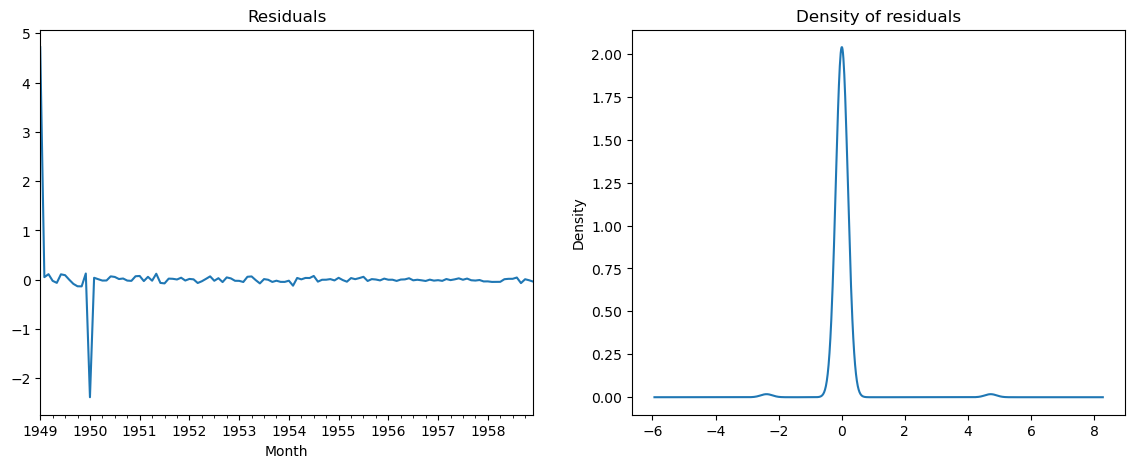

In [37]:
#res = data["Passengers"] - np.exp(final_model.predict(start = data.index[0], end = data.index[-1]))
res = final_model.resid
fig, ax = plt.subplots(1,2,figsize = (14,5))
res.plot(title = 'Residuals', ax = ax[0])
res.plot(title = 'Density of residuals', kind = 'kde', ax = ax[1])

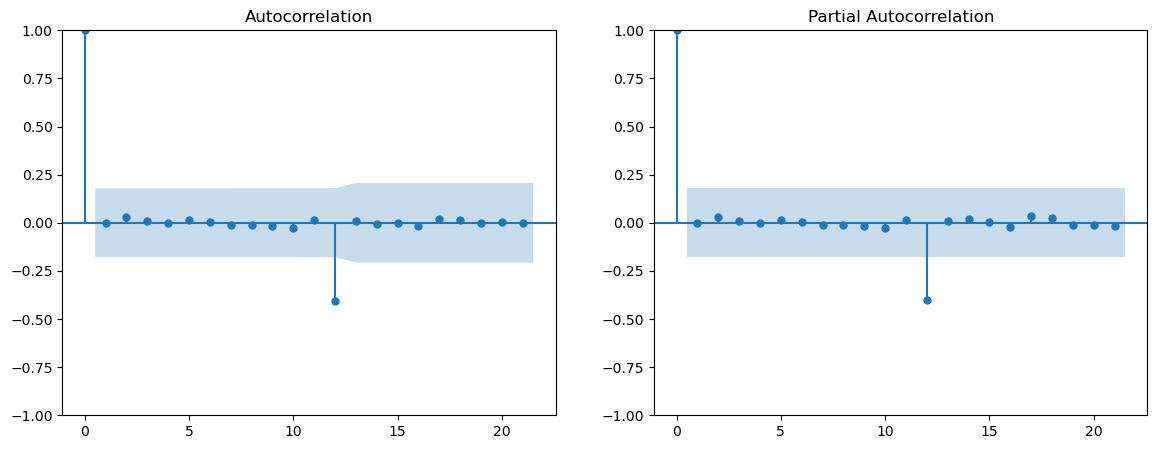

In [38]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14,5))
res_acf = plot_acf(res, ax = ax[0])
res_pacf = plot_pacf(res, ax = ax[1])

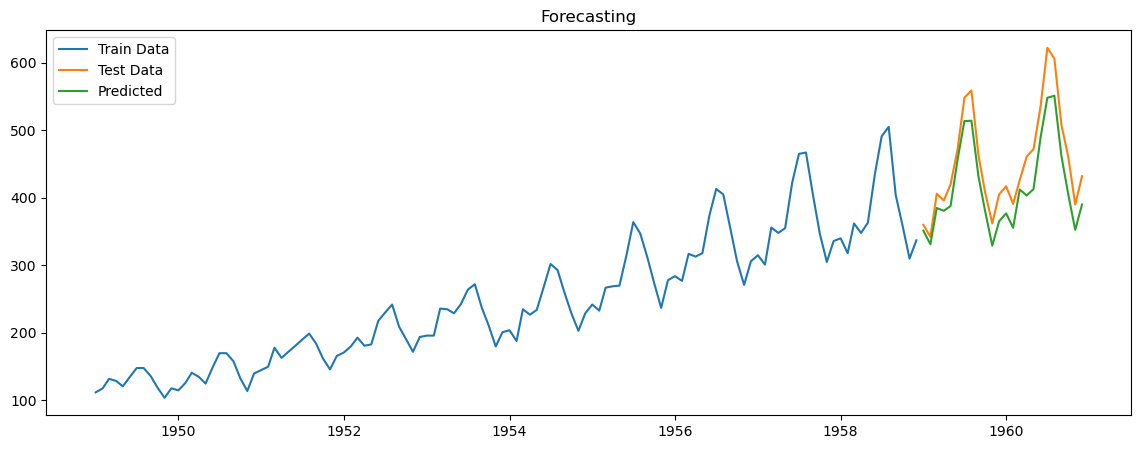

In [39]:
fig = plt.subplots(figsize = (14,5))

plt.plot(np.exp(train), label = 'Train Data')
plt.plot(np.exp(test), label = 'Test Data')
plt.plot(np.exp(model.forecast(steps = 24)), label = 'Predicted')
plt.title('Forecasting')
plt.legend()
plt.show()